<a href="https://colab.research.google.com/github/Anudeepsadda/Hybrid-Quantum-Classical-Deep-Learning-for-Breast-Cancer-Detection/blob/main/Hybrid_Quantum_BreastCancer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"anudeepsadda10","key":"8bd207ebaebed6668a61d59855fe7b56"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d aryashah2k/breast-ultrasound-images-dataset

Dataset URL: https://www.kaggle.com/datasets/aryashah2k/breast-ultrasound-images-dataset
License(s): CC0-1.0
 78% 153M/195M [00:00<00:00, 1.60GB/s]
100% 195M/195M [00:00<00:00, 1.10GB/s]


In [ ]:
!unzip -q breast-ultrasound-images-dataset.zip -d BUSI_Dataset

In [ ]:
import os

base_path = "BUSI_Dataset/Dataset_BUSI_with_GT"

print("Classes Found:")
print(os.listdir(base_path))

Classes Found:
['normal', 'benign', 'malignant']


In [ ]:
for folder in os.listdir(base_path):
    folder_path = os.path.join(base_path, folder)
    print(folder, "->", len(os.listdir(folder_path)), "images")

normal -> 266 images
benign -> 891 images
malignant -> 421 images


In [ ]:
import os

base_path = "BUSI_Dataset/Dataset_BUSI_with_GT"

print("Folders:", os.listdir(base_path))

Folders: ['normal', 'benign', 'malignant']


In [ ]:
import glob

mask_files = glob.glob(base_path + "/**/*_mask.png", recursive=True)

print("Total Mask Images Found:", len(mask_files))

for file in mask_files:
    os.remove(file)

print("Mask images removed successfully!")

Total Mask Images Found: 780
Mask images removed successfully!


In [ ]:
!pip install -q tensorflow

In [ ]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

In [ ]:
import tensorflow as tf

train_data = tf.keras.preprocessing.image_dataset_from_directory(
    base_path,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    validation_split=0.2,
    subset="training",
    seed=42
)

val_data = tf.keras.preprocessing.image_dataset_from_directory(
    base_path,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    validation_split=0.2,
    subset="validation",
    seed=42
)

Found 798 files belonging to 3 classes.
Using 639 files for training.
Found 798 files belonging to 3 classes.
Using 159 files for validation.


In [ ]:
class_names = train_data.class_names
print("Classes:", class_names)

Classes: ['benign', 'malignant', 'normal']


In [ ]:
from tensorflow.keras import layers

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

In [ ]:
normalization_layer = layers.Rescaling(1./255)

In [ ]:
train_data = train_data.map(lambda x, y: (normalization_layer(x), y))
val_data = val_data.map(lambda x, y: (normalization_layer(x), y))

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_data = train_data.prefetch(buffer_size=AUTOTUNE)
val_data = val_data.prefetch(buffer_size=AUTOTUNE)

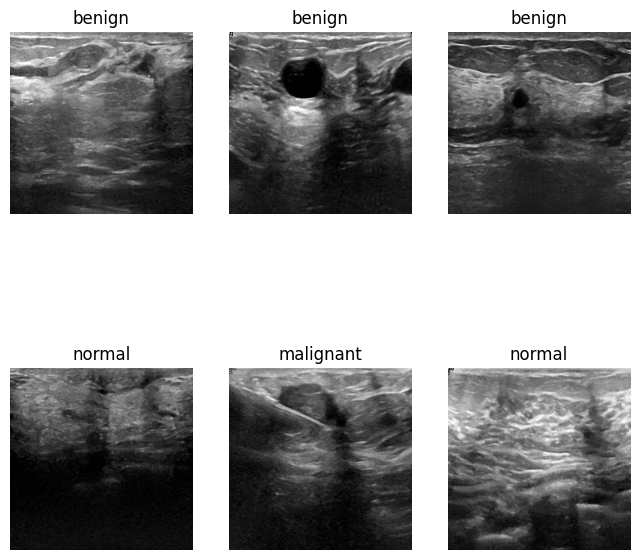

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,8))

for images, labels in train_data.take(1):
    for i in range(6):
        ax = plt.subplot(2,3,i+1)
        plt.imshow(images[i])
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [ ]:
!pip install -q pennylane

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.2/57.2 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 80.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 935.6/935.6 kB 59.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 88.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 84.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.9/167.9 kB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 100.3 MB/s eta 0:00:00


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
import pennylane as qml
import numpy as np

In [ ]:
resnet_base = tf.keras.applications.ResNet50(
    weights="imagenet",
    include_top=False,
    input_shape=(224, 224, 3)
)

# Freeze ResNet weights (Transfer Learning)
resnet_base.trainable = False

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
n_qubits = 4
n_layers = 2

dev = qml.device("default.qubit", wires=n_qubits)

In [ ]:
@qml.qnode(dev, interface="torch")
def quantum_circuit(inputs, weights):

    qml.AngleEmbedding(inputs, wires=range(n_qubits))
    qml.BasicEntanglerLayers(weights, wires=range(n_qubits))

    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

In [ ]:
!pip install -q torch torchvision
!pip install -q pennylane

In [ ]:
import torch
from pennylane.qnn import TorchLayer

weight_shapes = {"weights": (n_layers, n_qubits)}

qlayer = TorchLayer(quantum_circuit, weight_shapes)

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models

# Load Pretrained ResNet50
resnet = models.resnet50(pretrained=True)

# Remove Final Classification Layer
resnet.fc = nn.Identity()

# Freeze ResNet Parameters
for param in resnet.parameters():
    param.requires_grad = False

print("ResNet50 Feature Extractor Ready!")

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 190MB/s]


ResNet50 Feature Extractor Ready!


In [ ]:
class HybridResNetVQC(nn.Module):
    def __init__(self):
        super().__init__()

        # ResNet Feature Extractor
        self.resnet = resnet

        # Reduce features → 4 for quantum input
        self.fc1 = nn.Linear(2048, 4)

        # Quantum Layer (VQC)
        self.vqc = qlayer

        # Final Output Layer (3 Classes)
        self.fc2 = nn.Linear(4, 3)

    def forward(self, x):
        x = self.resnet(x)          # ResNet Features
        x = self.fc1(x)             # Reduce → 4 features
        x = self.vqc(x)             # Quantum Layer
        x = self.fc2(x)             # Classification Output
        return x

model = HybridResNetVQC()
print(model)

HybridResNetVQC(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
   

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

print("Using device:", device)

Using device: cuda


In [ ]:
!pip install -q torchvision

In [ ]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Dataset Path
data_dir = "BUSI_Dataset/Dataset_BUSI_with_GT"

# Image Transformations (ResNet Standard)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),  # Convert ultrasound gray → RGB
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

In [ ]:
full_dataset = datasets.ImageFolder(root=data_dir, transform=transform)

print("Total Images:", len(full_dataset))
print("Classes:", full_dataset.classes)

Total Images: 798
Classes: ['benign', 'malignant', 'normal']


In [ ]:
from torch.utils.data import random_split

train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size

train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

print("Training Samples:", len(train_dataset))
print("Validation Samples:", len(val_dataset))

Training Samples: 638
Validation Samples: 160


In [ ]:
BATCH_SIZE = 16

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

print("DataLoaders Ready!")

DataLoaders Ready!


In [ ]:
images, labels = next(iter(train_loader))

print("Batch Image Shape:", images.shape)
print("Batch Labels Shape:", labels.shape)

Batch Image Shape: torch.Size([16, 3, 224, 224])
Batch Labels Shape: torch.Size([16])


In [ ]:
import torch.optim as optim

# Loss Function (3-Class Classification)
criterion = nn.CrossEntropyLoss()

# Optimizer (Only train Quantum + Final Layers)
optimizer = optim.Adam(model.parameters(), lr=0.001)

print("Loss and Optimizer Ready!")

Loss and Optimizer Ready!


In [ ]:
def train_one_epoch(model, loader):
    model.train()

    running_loss = 0
    correct = 0
    total = 0

    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()

        # Forward Pass
        outputs = model(images)

        # Compute Loss
        loss = criterion(outputs, labels)

        # Backpropagation
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Accuracy
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(loader)
    epoch_acc = correct / total

    return epoch_loss, epoch_acc

In [ ]:
def validate(model, loader):
    model.eval()

    running_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)

            loss = criterion(outputs, labels)
            running_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss = running_loss / len(loader)
    val_acc = correct / total

    return val_loss, val_acc

In [ ]:
EPOCHS = 5

for epoch in range(EPOCHS):
    train_loss, train_acc = train_one_epoch(model, train_loader)
    val_loss, val_acc = validate(model, val_loader)

    print(f"Epoch [{epoch+1}/{EPOCHS}]")
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc:.4f}")
    print("-"*50)

Epoch [1/5]
Train Loss: 1.0480 | Train Acc: 0.5502
Val Loss:   1.0231 | Val Acc:   0.6000
--------------------------------------------------
Epoch [2/5]
Train Loss: 1.0081 | Train Acc: 0.5956
Val Loss:   0.9972 | Val Acc:   0.6125
--------------------------------------------------
Epoch [3/5]
Train Loss: 0.9872 | Train Acc: 0.6160
Val Loss:   1.0259 | Val Acc:   0.6188
--------------------------------------------------
Epoch [4/5]
Train Loss: 0.9807 | Train Acc: 0.6285
Val Loss:   0.9500 | Val Acc:   0.6062
--------------------------------------------------
Epoch [5/5]
Train Loss: 0.9513 | Train Acc: 0.6442
Val Loss:   0.9570 | Val Acc:   0.6500
--------------------------------------------------


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

all_preds = []
all_labels = []

model.eval()

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)

        _, predicted = torch.max(outputs, 1)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print("Predictions Collected Successfully!")

Predictions Collected Successfully!


In [ ]:
import matplotlib.pyplot as plt

cm = confusion_matrix(all_labels, all_preds)

print("Confusion Matrix:\n", cm)

Confusion Matrix:
 [[94  1  0]
 [37  5  0]
 [18  0  5]]


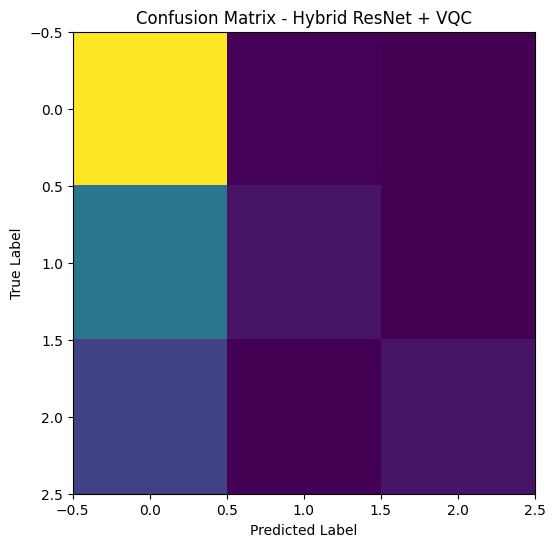

In [ ]:
plt.figure(figsize=(6,6))
plt.imshow(cm)
plt.title("Confusion Matrix - Hybrid ResNet + VQC")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [ ]:
class_names = full_dataset.classes

report = classification_report(
    all_labels,
    all_preds,
    target_names=class_names
)

print("Classification Report:\n")
print(report)

Classification Report:

              precision    recall  f1-score   support

      benign       0.63      0.99      0.77        95
   malignant       0.83      0.12      0.21        42
      normal       1.00      0.22      0.36        23

    accuracy                           0.65       160
   macro avg       0.82      0.44      0.45       160
weighted avg       0.74      0.65      0.56       160



In [ ]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

labels_array = [label for _, label in full_dataset]

class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(labels_array),
    y=labels_array
)

class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

print("Class Weights:", class_weights)

criterion = nn.CrossEntropyLoss(weight=class_weights)

Class Weights: tensor([0.5859, 1.2607, 2.0000], device='cuda:0')


In [ ]:
# Unfreeze last ResNet block
for name, param in model.resnet.named_parameters():
    if "layer4" in name:
        param.requires_grad = True

print("Last ResNet Block Unfrozen!")

Last ResNet Block Unfrozen!


In [ ]:
EPOCHS = 20

In [ ]:
@qml.qnode(dev, interface="torch")
def quantum_circuit(inputs, weights):

    qml.AngleEmbedding(inputs, wires=range(n_qubits))

    qml.StronglyEntanglingLayers(weights, wires=range(n_qubits))

    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

In [ ]:
weight_shapes = {"weights": (3, n_qubits, 3)}
qlayer = TorchLayer(quantum_circuit, weight_shapes)

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import torch

# Extract all labels from dataset
labels_array = [label for _, label in full_dataset]

# Compute balanced class weights
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(labels_array),
    y=labels_array
)

class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

print("Class Weights:", class_weights)

# Update Loss Function
criterion = nn.CrossEntropyLoss(weight=class_weights)

print("Weighted Loss Applied Successfully!")

Class Weights: tensor([0.5859, 1.2607, 2.0000], device='cuda:0')
Weighted Loss Applied Successfully!


In [ ]:
# Unfreeze only ResNet layer4 (last block)
for name, param in model.resnet.named_parameters():
    if "layer4" in name:
        param.requires_grad = True

print("ResNet layer4 unfrozen for fine-tuning!")

ResNet layer4 unfrozen for fine-tuning!


In [ ]:
import torch.optim as optim

optimizer = optim.Adam(model.parameters(), lr=0.0001)

print("Optimizer Updated with Fine-Tuning LR!")

Optimizer Updated with Fine-Tuning LR!


In [ ]:
EPOCHS = 5

for epoch in range(EPOCHS):
    train_loss, train_acc = train_one_epoch(model, train_loader)
    val_loss, val_acc = validate(model, val_loader)

    print(f"Epoch [{epoch+1}/{EPOCHS}]")
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc:.4f}")
    print("-"*60)

Epoch [1/5]
Train Loss: 0.7776 | Train Acc: 0.9984
Val Loss:   0.8841 | Val Acc:   0.8000
------------------------------------------------------------
Epoch [2/5]
Train Loss: 0.7733 | Train Acc: 0.9984
Val Loss:   0.8771 | Val Acc:   0.8313
------------------------------------------------------------
Epoch [3/5]
Train Loss: 0.7710 | Train Acc: 0.9969
Val Loss:   0.8790 | Val Acc:   0.8187
------------------------------------------------------------
Epoch [4/5]
Train Loss: 0.7626 | Train Acc: 0.9984
Val Loss:   0.8729 | Val Acc:   0.8250
------------------------------------------------------------
Epoch [5/5]
Train Loss: 0.7582 | Train Acc: 0.9984
Val Loss:   0.8629 | Val Acc:   0.8187
------------------------------------------------------------


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

all_preds = []
all_labels = []

model.eval()

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Print Classification Report
print("\nClassification Report (Current Model):\n")
print(classification_report(
    all_labels,
    all_preds,
    target_names=full_dataset.classes
))


Classification Report (Current Model):

              precision    recall  f1-score   support

      benign       0.87      0.86      0.87        95
   malignant       0.74      0.76      0.75        42
      normal       0.74      0.74      0.74        23

    accuracy                           0.82       160
   macro avg       0.79      0.79      0.79       160
weighted avg       0.82      0.82      0.82       160



In [ ]:
cm = confusion_matrix(all_labels, all_preds)

print("Confusion Matrix:\n")
print(cm)

Confusion Matrix:

[[82  8  5]
 [ 9 32  1]
 [ 3  3 17]]


In [ ]:
# Add dropout externally (no need to rewrite model class)

model.fc1 = nn.Sequential(
    nn.Linear(2048, 16),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(16, 4)
)

model.fc2 = nn.Sequential(
    nn.Dropout(0.3),
    nn.Linear(4, 3)
)

print("Dropout added successfully without rewriting model!")

Dropout added successfully without rewriting model!


In [ ]:
optimizer = optim.Adam(model.parameters(), lr=0.00005, weight_decay=1e-4)

print("Optimizer updated!")

Optimizer updated!


In [ ]:
# Move entire model (including newly added dropout layers) to GPU
model = model.to(device)

print("Model moved back to GPU successfully!")

Model moved back to GPU successfully!


In [ ]:
EPOCHS = 6

for epoch in range(EPOCHS):
    train_loss, train_acc = train_one_epoch(model, train_loader)
    val_loss, val_acc = validate(model, val_loader)

    print(f"Epoch [{epoch+1}/{EPOCHS}]")
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc:.4f}")
    print("-"*60)

Epoch [1/6]
Train Loss: 1.0937 | Train Acc: 0.2712
Val Loss:   1.0749 | Val Acc:   0.2625
------------------------------------------------------------
Epoch [2/6]
Train Loss: 1.0366 | Train Acc: 0.2806
Val Loss:   1.0567 | Val Acc:   0.2625
------------------------------------------------------------
Epoch [3/6]
Train Loss: 1.0514 | Train Acc: 0.2915
Val Loss:   1.0608 | Val Acc:   0.2625
------------------------------------------------------------
Epoch [4/6]
Train Loss: 1.0317 | Train Acc: 0.3056
Val Loss:   1.0631 | Val Acc:   0.2625
------------------------------------------------------------
Epoch [5/6]
Train Loss: 1.0264 | Train Acc: 0.3135
Val Loss:   1.0567 | Val Acc:   0.2625
------------------------------------------------------------
Epoch [6/6]
Train Loss: 1.0351 | Train Acc: 0.3150
Val Loss:   1.0515 | Val Acc:   0.2625
------------------------------------------------------------


In [ ]:
torch.save(model.state_dict(), "best_model.pth")

In [ ]:
# Rebuild original model (without dropout reset)

model = HybridResNetVQC()
model.to(device)

# Reapply weighted loss + fine-tuning optimizer
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=0.0001)

print("Original Hybrid Model Restored!")

Original Hybrid Model Restored!


In [ ]:
@qml.qnode(dev, interface="torch")
def quantum_circuit(inputs, weights):

    qml.AngleEmbedding(inputs, wires=range(n_qubits))
    qml.StronglyEntanglingLayers(weights, wires=range(n_qubits))

    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

In [ ]:
weight_shapes = {"weights": (3, n_qubits, 3)}
qlayer = TorchLayer(quantum_circuit, weight_shapes)

print("Quantum Circuit Upgraded Successfully!")

Quantum Circuit Upgraded Successfully!


In [ ]:
import torch.optim as optim
import torch.nn as nn

# Weighted Loss (important for malignant class)
criterion = nn.CrossEntropyLoss(weight=class_weights)

# Optimizer (fine-tuning)
optimizer = optim.Adam(model.parameters(), lr=0.0001)

print("Loss + Optimizer Ready!")

Loss + Optimizer Ready!


In [ ]:
def train_one_epoch(model, loader):
    model.train()

    running_loss = 0
    correct = 0
    total = 0

    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    return running_loss / len(loader), correct / total

In [ ]:
def validate(model, loader):
    model.eval()

    running_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return running_loss / len(loader), correct / total

In [ ]:
EPOCHS = 5

for epoch in range(EPOCHS):
    train_loss, train_acc = train_one_epoch(model, train_loader)
    val_loss, val_acc = validate(model, val_loader)

    print(f"\nEpoch {epoch+1}/{EPOCHS}")
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc:.4f}")
    print("-"*50)


Epoch 1/5
Train Loss: 0.9763 | Train Acc: 0.5627
Val Loss:   0.9619 | Val Acc:   0.5938
--------------------------------------------------

Epoch 2/5
Train Loss: 0.9171 | Train Acc: 0.5627
Val Loss:   0.9512 | Val Acc:   0.5938
--------------------------------------------------

Epoch 3/5
Train Loss: 0.8974 | Train Acc: 0.5627
Val Loss:   0.9370 | Val Acc:   0.5938
--------------------------------------------------

Epoch 4/5
Train Loss: 0.8774 | Train Acc: 0.5627
Val Loss:   0.9261 | Val Acc:   0.5938
--------------------------------------------------

Epoch 5/5
Train Loss: 0.8626 | Train Acc: 0.5627
Val Loss:   0.9200 | Val Acc:   0.5938
--------------------------------------------------


In [ ]:
from sklearn.metrics import classification_report

all_preds = []
all_labels = []

model.eval()

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print("\nClassification Report:\n")
print(classification_report(all_labels, all_preds, target_names=full_dataset.classes))


Classification Report:

              precision    recall  f1-score   support

      benign       0.59      1.00      0.75        95
   malignant       0.00      0.00      0.00        42
      normal       0.00      0.00      0.00        23

    accuracy                           0.59       160
   macro avg       0.20      0.33      0.25       160
weighted avg       0.35      0.59      0.44       160



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
best_val_acc = 0

EPOCHS = 10

for epoch in range(EPOCHS):
    train_loss, train_acc = train_one_epoch(model, train_loader)
    val_loss, val_acc = validate(model, val_loader)

    print(f"\nEpoch {epoch+1}/{EPOCHS}")
    print(f"Train Acc: {train_acc:.4f}")
    print(f"Val Acc:   {val_acc:.4f}")

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_hybrid_model.pth")
        print("✅ Best Model Saved!")

print("\nTraining Finished!")
print("Best Validation Accuracy:", best_val_acc)


Epoch 1/10
Train Acc: 0.5627
Val Acc:   0.5938
✅ Best Model Saved!

Epoch 2/10
Train Acc: 0.5627
Val Acc:   0.5938

Epoch 3/10
Train Acc: 0.5627
Val Acc:   0.5938

Epoch 4/10
Train Acc: 0.5627
Val Acc:   0.5938

Epoch 5/10
Train Acc: 0.5627
Val Acc:   0.5938

Epoch 6/10
Train Acc: 0.5627
Val Acc:   0.5938

Epoch 7/10
Train Acc: 0.5627
Val Acc:   0.5938

Epoch 8/10
Train Acc: 0.5627
Val Acc:   0.5938

Epoch 9/10
Train Acc: 0.5737
Val Acc:   0.6375
✅ Best Model Saved!

Epoch 10/10
Train Acc: 0.6865
Val Acc:   0.6625
✅ Best Model Saved!

Training Finished!
Best Validation Accuracy: 0.6625


In [ ]:
model.load_state_dict(torch.load("best_hybrid_model.pth"))
print("✅ Best Model Restored!")

✅ Best Model Restored!


In [ ]:
from sklearn.metrics import classification_report

all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print("\nClassification Report (Best Model):\n")
print(classification_report(
    all_labels, all_preds,
    target_names=full_dataset.classes,
    zero_division=0
))


Classification Report (Best Model):

              precision    recall  f1-score   support

      benign       0.64      0.97      0.77        95
   malignant       0.82      0.33      0.47        42
      normal       0.00      0.00      0.00        23

    accuracy                           0.66       160
   macro avg       0.49      0.43      0.42       160
weighted avg       0.60      0.66      0.58       160



In [ ]:
# Unfreeze ResNet layer4 again
for name, param in model.resnet.named_parameters():
    if "layer4" in name:
        param.requires_grad = True

# Weighted Loss
criterion = nn.CrossEntropyLoss(weight=class_weights)

# Optimizer for fine-tuning
optimizer = optim.Adam(model.parameters(), lr=0.0001)

print("Fine-tuning + Weighted Loss Restored!")

Fine-tuning + Weighted Loss Restored!


In [ ]:
EPOCHS = 5

for epoch in range(EPOCHS):
    train_loss, train_acc = train_one_epoch(model, train_loader)
    val_loss, val_acc = validate(model, val_loader)

    print(f"Epoch {epoch+1}/{EPOCHS}")
    print(f"Train Acc: {train_acc:.4f}")
    print(f"Val Acc:   {val_acc:.4f}")
    print("-"*50)

Epoch 1/5
Train Acc: 0.7226
Val Acc:   0.7188
--------------------------------------------------
Epoch 2/5
Train Acc: 0.7931
Val Acc:   0.6937
--------------------------------------------------
Epoch 3/5
Train Acc: 0.8103
Val Acc:   0.7063
--------------------------------------------------
Epoch 4/5
Train Acc: 0.8260
Val Acc:   0.7063
--------------------------------------------------
Epoch 5/5
Train Acc: 0.8229
Val Acc:   0.7250
--------------------------------------------------


In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),

    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),

    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

print("Stronger Augmentation Applied!")

Stronger Augmentation Applied!


In [ ]:
full_dataset = datasets.ImageFolder(root=data_dir, transform=transform)
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

print("DataLoaders Updated!")

DataLoaders Updated!


In [ ]:
for name, param in model.resnet.named_parameters():
    if "layer3" in name or "layer4" in name:
        param.requires_grad = True

print("Layer3 + Layer4 Unfrozen!")

Layer3 + Layer4 Unfrozen!


In [ ]:
import torch.optim as optim

# Fine-tuning optimizer (small LR)
optimizer = optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=0.00005
)

print("Optimizer Updated for Layer3+Layer4 Fine-Tuning!")

Optimizer Updated for Layer3+Layer4 Fine-Tuning!


In [ ]:
EPOCHS = 10

for epoch in range(EPOCHS):
    train_loss, train_acc = train_one_epoch(model, train_loader)
    val_loss, val_acc = validate(model, val_loader)

    print(f"\nEpoch {epoch+1}/{EPOCHS}")
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc:.4f}")
    print("-"*60)


Epoch 1/10
Train Loss: 0.8760 | Train Acc: 0.7085
Val Loss:   0.8127 | Val Acc:   0.7937
------------------------------------------------------------

Epoch 2/10
Train Loss: 0.8256 | Train Acc: 0.7335
Val Loss:   0.8049 | Val Acc:   0.7875
------------------------------------------------------------

Epoch 3/10
Train Loss: 0.8116 | Train Acc: 0.7257
Val Loss:   0.7884 | Val Acc:   0.8125
------------------------------------------------------------

Epoch 4/10
Train Loss: 0.8119 | Train Acc: 0.7398
Val Loss:   0.7871 | Val Acc:   0.7875
------------------------------------------------------------

Epoch 5/10
Train Loss: 0.7963 | Train Acc: 0.7586
Val Loss:   0.7997 | Val Acc:   0.8063
------------------------------------------------------------

Epoch 6/10
Train Loss: 0.7767 | Train Acc: 0.8433
Val Loss:   0.7924 | Val Acc:   0.8812
------------------------------------------------------------

Epoch 7/10
Train Loss: 0.7670 | Train Acc: 0.8887
Val Loss:   0.7772 | Val Acc:   0.8688
----

In [ ]:
torch.save(model.state_dict(), "final_best_model.pth")
print("Final Model Saved Successfully!")

Final Model Saved Successfully!


In [ ]:
from sklearn.metrics import classification_report

all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print("\nClassification Report After Fine-Tuning:\n")
print(classification_report(
    all_labels, all_preds,
    target_names=full_dataset.classes,
    zero_division=0
))


Classification Report After Fine-Tuning:

              precision    recall  f1-score   support

      benign       0.87      0.97      0.91        88
   malignant       0.98      0.82      0.89        49
      normal       0.90      0.83      0.86        23

    accuracy                           0.90       160
   macro avg       0.92      0.87      0.89       160
weighted avg       0.91      0.90      0.90       160



In [ ]:
# Load your final best model weights
model.load_state_dict(torch.load("final_best_model.pth"))
model.eval()

print("✅ Best Model Loaded for Prediction!")

✅ Best Model Loaded for Prediction!


In [ ]:
from google.colab import files

uploaded = files.upload()

Saving malignant (108).png to malignant (108).png


In [ ]:
from PIL import Image
import torch.nn.functional as F

class_names = full_dataset.classes  # ['benign','malignant','normal']

def predict_image(img_path):
    img = Image.open(img_path).convert("RGB")
    img = transform(img).unsqueeze(0).to(device)

    with torch.no_grad():
        outputs = model(img)
        probs = F.softmax(outputs, dim=1)
        pred_class = torch.argmax(probs, dim=1).item()

    print("✅ Prediction Result:")
    print("Predicted Class:", class_names[pred_class])
    print("Confidence:", probs[0][pred_class].item())

    return pred_class, img

In [ ]:
img_path = list(uploaded.keys())[0]

pred_class, input_tensor = predict_image(img_path)

✅ Prediction Result:
Predicted Class: malignant
Confidence: 0.4112647473812103


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
def grad_cam(model, input_tensor, target_class):

    # Hook gradients
    gradients = []
    activations = []

    def backward_hook(module, grad_in, grad_out):
        gradients.append(grad_out[0])

    def forward_hook(module, inp, out):
        activations.append(out)

    # Target layer: ResNet last conv block
    target_layer = model.resnet.layer4

    # Register hooks
    target_layer.register_forward_hook(forward_hook)
    target_layer.register_backward_hook(backward_hook)

    # Forward
    output = model(input_tensor)
    loss = output[0, target_class]

    # Backward
    model.zero_grad()
    loss.backward()

    # Get data
    grad = gradients[0].cpu().data.numpy()
    act = activations[0].cpu().data.numpy()

    # Compute weights
    weights = np.mean(grad, axis=(2, 3))

    cam = np.zeros(act.shape[2:], dtype=np.float32)

    for i, w in enumerate(weights[0]):
        cam += w * act[0, i, :, :]

    cam = np.maximum(cam, 0)
    cam = cv2.resize(cam, (224, 224))
    cam = cam / cam.max()

    return cam

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1866: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


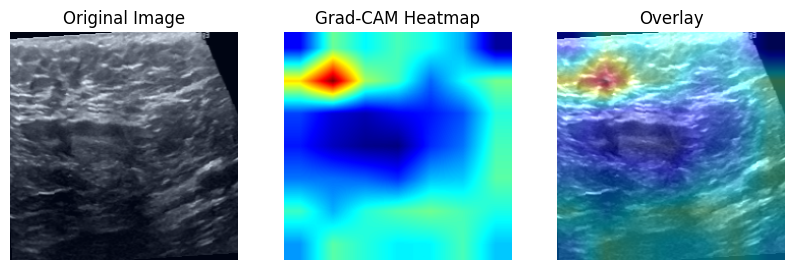

In [ ]:
cam = grad_cam(model, input_tensor, pred_class)

# Convert tensor back to image
img = input_tensor.squeeze().permute(1,2,0).cpu().numpy()
img = (img - img.min()) / (img.max() - img.min())

heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
heatmap = np.float32(heatmap) / 255

overlay = heatmap * 0.4 + img

plt.figure(figsize=(10,4))

plt.subplot(1,3,1)
plt.title("Original Image")
plt.imshow(img)
plt.axis("off")

plt.subplot(1,3,2)
plt.title("Grad-CAM Heatmap")
plt.imshow(heatmap)
plt.axis("off")

plt.subplot(1,3,3)
plt.title("Overlay")
plt.imshow(overlay)
plt.axis("off")

plt.show()